In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

In [2]:
# import librarys
import torch
import numpy as np
import torch.utils.data as data
from torchvision import transforms
from PIL import Image
import os
import random
import cv2
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

is_cuda_available = torch.cuda.is_available()

device = torch.device("cuda" if is_cuda_available else "cpu")

In [3]:
# set up random seed

seed_value = 42

torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)  # if using multiple GPUs
np.random.seed(seed_value)
random.seed(seed_value)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
!nvidia-smi

Sun Apr  7 21:07:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.05              Driver Version: 535.86.05    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        On  | 00000000:03:00.0 Off |                  N/A |
| 30%   28C    P8              23W / 350W |      5MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
# Load images and masks for segmentation

# Function to load image paths and their corresponding mask paths
def load_images_and_labels(base_path, class_label):
    images = []
    labels = []
    for filename in os.listdir(base_path):
        filepath = os.path.join(base_path, filename)
        if filepath.endswith(".png") and not "_mask" in filepath:
            images.append(filepath)
            labels.append(class_label)
    return images, labels

# Load benign and malignant images and masks
benign_images, benign_labels = load_images_and_labels("./Dataset_BUSI_with_GT/benign/", 0)
malignant_images, malignant_labels  = load_images_and_labels("./Dataset_BUSI_with_GT/malignant/", 1)

# Combine benign and malignant images and masks
images = benign_images + malignant_images
labels = benign_labels + malignant_labels

# Split the dataset into training and testing sets
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.2, random_state=42)

class ToLabel:

    def __call__(self, image):
        return torch.from_numpy(image).type(torch.LongTensor)
    
# Dataset class for segmentation
class BreastCancerSegmentation(data.Dataset):
    def __init__(self, images, labels, img_width, img_height, is_augment=True):
        self.images = images
        self.labels = labels
        self.img_width = img_width
        self.img_height = img_height
        self.is_augment = is_augment

    def __getitem__(self, index):
        image = Image.open(self.images[index]).convert("RGB").resize((self.img_width, self.img_height))
        label = torch.from_numpy(np.array(self.labels))[index].type(torch.LongTensor)
        image = np.array(image)
        img_new = np.float32(image)
        img_new = img_new /127.5 -1

        if self.is_augment == True:
            flipCode = random.choice([-1, 0, 1, 2, 3])
            if flipCode == 2:
                height, width = self.img_height, self.img_width
                center = (width / 2, height / 2)
                degree = random.choice([-5, -4, -3, -2, -1, 1, 2, 3, 4, 5])
                M = cv2.getRotationMatrix2D(center, degree, 1.0)
                img_new = cv2.warpAffine(img_new, M, (height, width))
            elif flipCode != 3:
                img_new = cv2.flip(img_new, flipCode)

        tfms = transforms.Compose([
            transforms.ToTensor()
        ])


        img_new = tfms(img_new)

        return img_new, label

    def __len__(self):
        return len(self.images)


# Load training set and test set into Torch datasets
train_dataset = BreastCancerSegmentation(images_train, labels_train, 224, 224, is_augment=True)
test_dataset = BreastCancerSegmentation(images_test, labels_test, 224, 224, is_augment=False)

# DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

# Print the number of samples in training set and testing set
print('Training samples #: ', len(train_dataset))
print('Test samples #: ', len(test_dataset))



Training samples #:  517
Test samples #:  130


In [6]:

model = models.vgg16(pretrained=True)
num_features = model.classifier[0].in_features  # Get the number of input features of the first layer in the classifier
new_classifier = nn.Sequential(
    nn.Linear(num_features, 4096),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, 2)  # Change the out_features to 2 for binary classification
)
model.classifier = new_classifier

model = model.to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# loss
loss_function = torch.nn.CrossEntropyLoss()


/home/khuang@kean.edu/anaconda3/envs/pytorch_env_new/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/khuang@kean.edu/anaconda3/envs/pytorch_env_new/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Train loss: 0.5745249977617553
Epoch 1, Test loss: 0.564010868469874
Epoch 2, Train loss: 0.4617357235966307
Epoch 2, Test loss: 0.4224473138650258
Epoch 3, Train loss: 0.41808651319958945
Epoch 3, Test loss: 0.6819688579222808
Epoch 4, Train loss: 0.47657380456274206
Epoch 4, Test loss: 0.38862187663714093
Epoch 5, Train loss: 0.4144880299766858
Epoch 5, Test loss: 0.3464401678906547
Epoch 6, Train loss: 0.33443181148984213
Epoch 6, Test loss: 0.503835430679222
Epoch 7, Train loss: 0.3018461999793847
Epoch 7, Test loss: 0.31815603458219105
Epoch 8, Train loss: 0.27437875600475253
Epoch 8, Test loss: 0.377606588933203
Epoch 9, Train loss: 0.22178601671123144
Epoch 9, Test loss: 0.5323595189385943
Epoch 10, Train loss: 0.27654950399741984
Epoch 10, Test loss: 0.36135929491784835
Epoch 11, Train loss: 0.21056523281290676
Epoch 11, Test loss: 0.430719767179754
Epoch 12, Train loss: 0.20219269095722472
Epoch 12, Test loss: 0.6301849376306765
Epoch 13, Train loss: 0.152500248429450

Epoch 100, Test loss: 1.3798251897096634


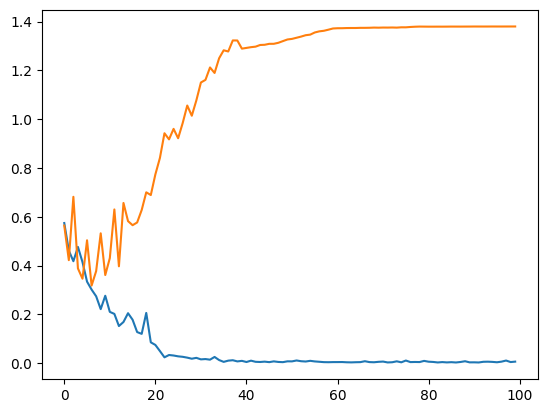

In [7]:
# Train the model
epoch_training_loss = []
epoch_test_loss = []
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
for epoch in range(100):
    model.train()
    train_loss = []
    for batch_idx, (image, seg_label) in enumerate(train_loader):
        image, seg_label = image.to(device), seg_label.to(device)
        optimizer.zero_grad()

        # Forward pass
        output = model(image)

        # Calculate loss
        loss = loss_function(output, seg_label)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    print(f'Epoch {epoch+1}, Train loss: {np.mean(train_loss)}')
    epoch_training_loss.append(np.mean(train_loss))
    scheduler.step()

    # Evaluate on test data
    model.eval()
    test_loss = []
    with torch.no_grad():
        for image, seg_label in test_loader:
            image, seg_label = image.to(device), seg_label.to(device)
            y_predict = model(image)
            loss = loss_function(y_predict, seg_label)
            test_loss.append(loss.item())
    print(f'Epoch {epoch+1}, Test loss: {np.mean(test_loss)}')
    epoch_test_loss.append(np.mean(test_loss))


# Draw curves here

import matplotlib.pyplot as plt

plt.plot(epoch_training_loss)

plt.plot(epoch_test_loss)
torch.save(model, "./save_models/VGG16_cls.pt")

In [7]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, confusion_matrix
model = torch.load("./save_models/VGG16_cls.pt")
import numpy as np
import torch
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, confusion_matrix

def evaluate_model(model, test_loader, threshold=0.5):
    model.eval()  # Set the model to evaluation mode
    model = model.to(device)
    
    true_labels = []
    probabilities = []
    predictions = []  # Correctly initialize the predictions list

    with torch.no_grad():  # Do not compute gradients
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Probabilities for the positive class
            preds = (probs >= threshold).cpu().numpy().astype(int)  # Binary predictions based on the threshold
            
            true_labels.extend(labels.cpu().numpy())
            probabilities.extend(probs.cpu().numpy())
            predictions.extend(preds)  # Add the predictions to the list

    # Convert lists to numpy arrays for consistency
    true_labels = np.array(true_labels)
    probabilities = np.array(probabilities)
    predictions = np.array(predictions)
    
    # Compute metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    auc = roc_auc_score(true_labels, probabilities)  # AUC using probabilities

    # Compute confusion matrix and extract TN, FP, FN, TP for calculating TPR and FPR
    tn, fp, fn, tp = confusion_matrix(true_labels, predictions).ravel()
    tpr = tp / (tp + fn)  # True Positive Rate
    fpr = fp / (fp + tn)  # False Positive Rate
    
    return accuracy, precision, f1, auc, tpr, fpr

# Assuming 'device' and 'test_loader' are already defined
# Evaluate the model and print the metrics
accuracy, precision, f1, auc, tpr, fpr = evaluate_model(model, test_loader)
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nF1 Score: {f1}\nAUC: {auc}\nTPR: {tpr}\nFPR: {fpr}")


Accuracy: 0.8384615384615385
Precision: 0.7142857142857143
F1 Score: 0.7407407407407408
AUC: 0.9188503803888419
TPR: 0.7692307692307693
FPR: 0.13186813186813187
